# Лабораторная работа №5 (проведение исследований с алгоритмом GradientBoosting)

In [118]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import f1_score, balanced_accuracy_score, precision_score, recall_score

import matplotlib.pyplot as plt

## 1. Выбор начальных условий
### Набор данных для классификации

In [119]:
glass_dataset = fetch_ucirepo(id=42)


In [120]:
df = pd.DataFrame(data=glass_dataset.data.features)
df['Glass'] = glass_dataset.data.targets

In [121]:
target_column = "Glass"

class_names = [
    "building_windows_float_processed",
    "building_windows_non_float_processed",
    "vehicle_windows_float_processed",
    "vehicle_windows_non_float_processed",
    "containers",
    "tableware",
    "headlamps",
    ]

# df[target_column] = df[target_column].apply(lambda x: class_names[x-1])
# df[target_column].head()

Разобьем выборку на обучающую и валидационную

In [122]:
train, valid = train_test_split(df, train_size=0.8, random_state=42, shuffle=True, stratify=df[target_column])

In [123]:
X_train = train.drop(columns=target_column, inplace=False)
y_train = train[target_column]

X_valid = valid.drop(columns=target_column, inplace=False)
y_valid = valid[target_column]

## 2. Создание бейзлайна и оценка качества

### Обучение модели

Определим модель и обучим модель

In [124]:
model = GradientBoostingClassifier()
model.fit(X_train, y_train)

GradientBoostingClassifier()

Сделаем предсказания

In [125]:
train_predict = model.predict(X_train)
valid_predict = model.predict(X_valid)

### Оценка качества модели

У нас мультиклассовая классификация, но класс `vehicle_windows_non_float_processed` отсутствует среди истинных меток классов

In [126]:
df[target_column].nunique()

6

Поэтому метрики будем вычислять, используя параметры `average='macro'` и `zero_division=1` 

In [127]:
# Расчет метрик для тренировочных предсказаний
train_f1 = f1_score(y_train, train_predict, average='macro')
train_balanced_accuracy = balanced_accuracy_score(y_train, train_predict)
train_precision = precision_score(y_train, train_predict, average='macro', zero_division=1)
train_recall = recall_score(y_train, train_predict, average='macro')

# Расчет метрик для валидационных предсказаний
valid_f1 = f1_score(y_valid, valid_predict, average='macro')
valid_balanced_accuracy = balanced_accuracy_score(y_valid, valid_predict)
valid_precision = precision_score(y_valid, valid_predict, average='macro', zero_division=1)
valid_recall = recall_score(y_valid, valid_predict, average='macro')

# Сводка метрик в таблицу для удобного отображения
metrics_df = pd.DataFrame({
    'Метрика': ['F1', 'Balanced Accuracy', 'Precision', 'Recall'],
    'Тренировочная выборка': [train_f1, train_balanced_accuracy, train_precision, train_recall],
    'Валидационная выборка': [valid_f1, valid_balanced_accuracy, valid_precision, valid_recall]
})

In [128]:
metrics_df.head()

,Метрика,Тренировочная выборка,Валидационная выборка
0,F1,1.0,0.800760
1,Balanced Accuracy,1.0,0.819841
2,Precision,1.0,0.806105
3,Recall,1.0,0.819841


Визуализируем метрики

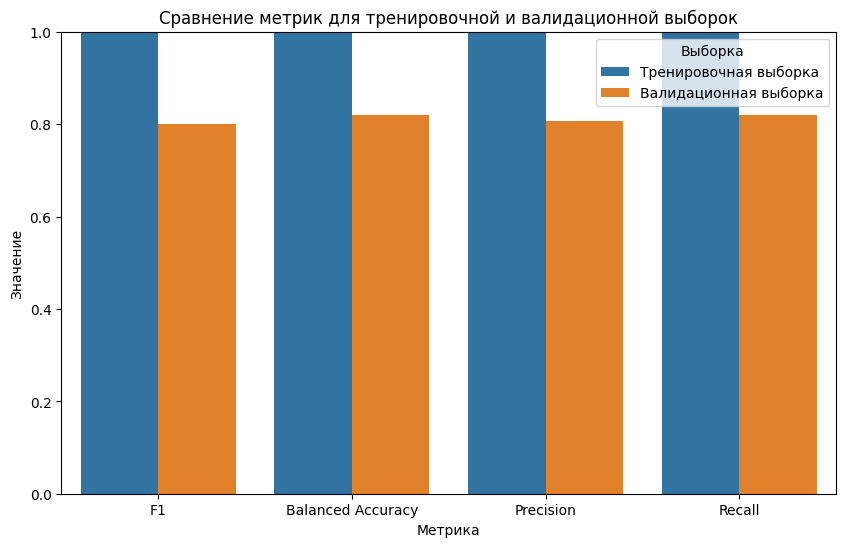

In [129]:
# Визуализация метрик
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df.melt(id_vars='Метрика', var_name='Выборка', value_name='Значение'),
            x='Метрика', y='Значение', hue='Выборка')
plt.title('Сравнение метрик для тренировочной и валидационной выборок')
plt.ylim(0, 1)
plt.legend(title='Выборка')
plt.show()

## 3. Улучшение бейзлайна

### Препроцессинг данных

In [130]:
df_optimized = df.copy()

Найден дубликат, удалим его

In [131]:
df_optimized = df_optimized.drop_duplicates()

In [132]:
# Обработка выбросов
def remove_outliers(data, columns, threshold=1.5):
    for col in columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]
    return data

df_optimized = remove_outliers(df_optimized, df_optimized.columns)

In [133]:
X = df_optimized.drop(target_column, axis=1)
y = df_optimized[target_column]

Скалирование данных

In [134]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Балансировка классов

In [135]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

In [136]:
new_X_train, new_X_valid, new_y_train, new_y_valid = train_test_split(
    X_resampled, 
    y_resampled, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_resampled
    )


Решим проблему высокой корреляции данных

In [137]:
pca = PCA(n_components=new_X_train.shape[1])
pca.fit(new_X_train)

PCA(n_components=9)

Проверим сколько компонент дают 90% дисперсии

In [138]:
pca.explained_variance_ratio_.round(2)

array([0.27, 0.23, 0.15, 0.13, 0.1 , 0.06, 0.05, 0.  , 0.  ])

Достаточно 7-и компонент

### Обучение модели с новыми данными

Переопределим модель

In [139]:
model = Pipeline((
    ("pca", PCA(n_components=7)),
    ("model", GradientBoostingClassifier())
))

In [140]:
model.fit(new_X_train, new_y_train)

Pipeline(steps=[('pca', PCA(n_components=7)),
                ('model', GradientBoostingClassifier())])

Сделаем предсказания

In [141]:
train_predict = model.predict(new_X_train)
valid_predict = model.predict(new_X_valid)

### Оценка качетсва модели с улучшеным бейзлайном

In [142]:
# Расчет метрик для тренировочных предсказаний
train_f1 = f1_score(new_y_train, train_predict, average='macro')
train_balanced_accuracy = balanced_accuracy_score(new_y_train, train_predict)
train_precision = precision_score(new_y_train, train_predict, average='macro', zero_division=1)
train_recall = recall_score(new_y_train, train_predict, average='macro')

# Расчет метрик для валидационных предсказаний
valid_f1 = f1_score(new_y_valid, valid_predict, average='macro')
valid_balanced_accuracy = balanced_accuracy_score(new_y_valid, valid_predict)
valid_precision = precision_score(new_y_valid, valid_predict, average='macro', zero_division=1)
valid_recall = recall_score(new_y_valid, valid_predict, average='macro')

# Сводка метрик в таблицу для удобного отображения
metrics_df = pd.DataFrame({
    'Метрика': ['F1', 'Balanced Accuracy', 'Precision', 'Recall'],
    'Тренировочная выборка': [train_f1, train_balanced_accuracy, train_precision, train_recall],
    'Валидационная выборка': [valid_f1, valid_balanced_accuracy, valid_precision, valid_recall]
    })

In [143]:
metrics_df.head()

,Метрика,Тренировочная выборка,Валидационная выборка
0,F1,1.0,0.863158
1,Balanced Accuracy,1.0,0.862963
2,Precision,1.0,0.872054
3,Recall,1.0,0.862963


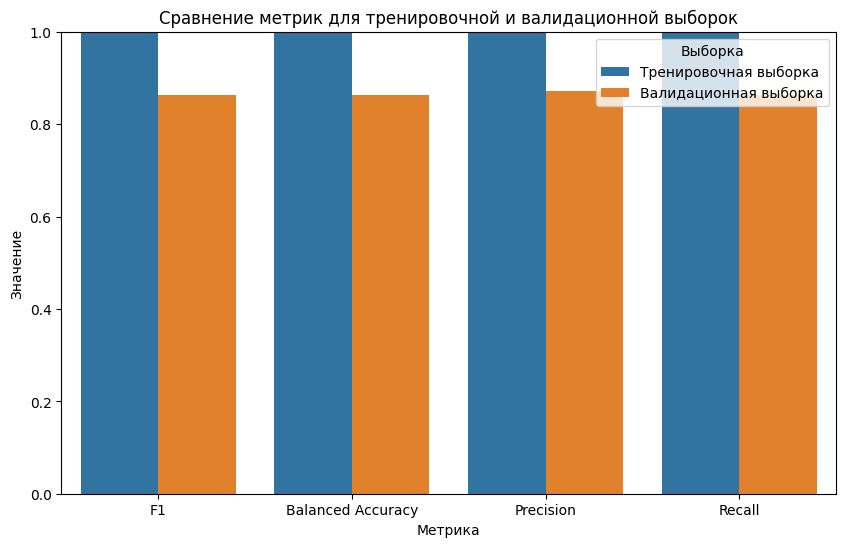

In [144]:
# Визуализация метрик
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df.melt(id_vars='Метрика', var_name='Выборка', value_name='Значение'),
            x='Метрика', y='Значение', hue='Выборка')
plt.title('Сравнение метрик для тренировочной и валидационной выборок')
plt.ylim(0, 1)
plt.legend(title='Выборка')
plt.show()

### Резюме:
На качество модели повлияли, как входные данные, так и параметры самой модели:
- При помощи квантилей я удалил выбросы
- Скалировал данные StandartScaller'ом
- Избавился от дисбалана классов
- Избавился от высокой кореляции фичей

## 4. Имплементация алгоритма машинного обучения

### Реализация модели

In [156]:
class MyGradientBoostingClassifier:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        """
        Initialize the gradient boosting classifier.

        Parameters:
        n_estimators: int
            The number of boosting stages to run.
        learning_rate: float
            Step size shrinkage applied to each tree's contribution.
        max_depth: int
            The maximum depth of each decision tree.
        """
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.trees = []
        self.learning_rate = learning_rate
        self.classes_ = None

    def fit(self, X, y):
        """
        Fit the model to the data.

        Parameters:
        X: ndarray of shape (n_samples, n_features)
            Training data.
        y: ndarray of shape (n_samples,)
            Target values.
        """
        # Store the unique class labels
        self.classes_ = np.unique(y)
        k = len(self.classes_)

        # Initialize predictions for each class
        self.initial_predictions = np.zeros(k)
        self.trees = {c: [] for c in range(k)}

        for c in range(k):
            # Binary relevance for class c
            y_binary = (y == self.classes_[c]).astype(int)

            # Initialize with the log odds of the positive class
            initial_odds = np.log(np.mean(y_binary) / (1 - np.mean(y_binary))) if np.mean(y_binary) > 0 else 0
            self.initial_predictions[c] = initial_odds

            y_pred = np.full(y_binary.shape, initial_odds)

            for _ in range(self.n_estimators):
                # Compute pseudo-residuals
                residuals = y_binary - self._sigmoid(y_pred)

                # Fit a regression tree to the residuals
                tree = DecisionTreeRegressor(max_depth=self.max_depth)
                tree.fit(X, residuals)

                # Update the predictions
                update = tree.predict(X)
                y_pred += self.learning_rate * update

                # Save the tree
                self.trees[c].append(tree)

    def predict_proba(self, X):
        """
        Predict class probabilities using the model.

        Parameters:
        X: ndarray of shape (n_samples, n_features)
            Samples.

        Returns:
        proba: ndarray of shape (n_samples, n_classes)
            Class probabilities.
        """
        n_samples = X.shape[0]
        k = len(self.classes_)
        y_pred = np.zeros((n_samples, k))

        for c in range(k):
            pred = np.full(n_samples, self.initial_predictions[c])
            for tree in self.trees[c]:
                pred += self.learning_rate * tree.predict(X)
            y_pred[:, c] = self._sigmoid(pred)

        # Normalize probabilities to sum to 1
        return y_pred / y_pred.sum(axis=1, keepdims=True)

    def predict(self, X):
        """
        Predict class labels for samples in X.

        Parameters:
        X: ndarray of shape (n_samples, n_features)
            Samples.

        Returns:
        y_pred: ndarray of shape (n_samples,)
            Predicted class labels.
        """
        proba = self.predict_proba(X)
        return self.classes_[np.argmax(proba, axis=1)]

    def _sigmoid(self, x):
        """
        Compute the sigmoid function.

        Parameters:
        x: ndarray
            Input array.

        Returns:
        result: ndarray
            Sigmoid of input array.
        """
        return 1 / (1 + np.exp(-x))

### Обучение 

In [157]:
model = MyGradientBoostingClassifier()
model.fit(X_train, y_train)

In [158]:
train_predict = model.predict(X_train)
valid_predict = model.predict(X_valid)

In [160]:
np.unique(train_predict)

array([1, 2, 3, 5, 6, 7], dtype=int64)

###  Оценка качества модели

In [161]:
# Расчет метрик для тренировочных предсказаний
train_f1 = f1_score(y_train, train_predict, average='macro')
train_balanced_accuracy = balanced_accuracy_score(y_train, train_predict)
train_precision = precision_score(y_train, train_predict, average='macro', zero_division=1)
train_recall = recall_score(y_train, train_predict, average='macro', zero_division=1)

# Расчет метрик для валидационных предсказаний
valid_f1 = f1_score(y_valid, valid_predict, average='macro')
valid_balanced_accuracy = balanced_accuracy_score(y_valid, valid_predict)
valid_precision = precision_score(y_valid, valid_predict, average='macro', zero_division=1)
valid_recall = recall_score(y_valid, valid_predict, average='macro', zero_division=1)

# Сводка метрик в таблицу для удобного отображения
metrics_df = pd.DataFrame({
    'Метрика': ['F1', 'Balanced Accuracy', 'Precision', 'Recall'],
    'Тренировочная выборка': [train_f1, train_balanced_accuracy, train_precision, train_recall],
    'Валидационная выборка': [valid_f1, valid_balanced_accuracy, valid_precision, valid_recall]
})

In [162]:
metrics_df.head()

,Метрика,Тренировочная выборка,Валидационная выборка
0,F1,0.935146,0.825223
1,Balanced Accuracy,0.917642,0.851587
2,Precision,0.974050,0.830808
3,Recall,0.917642,0.851587


Визуализация

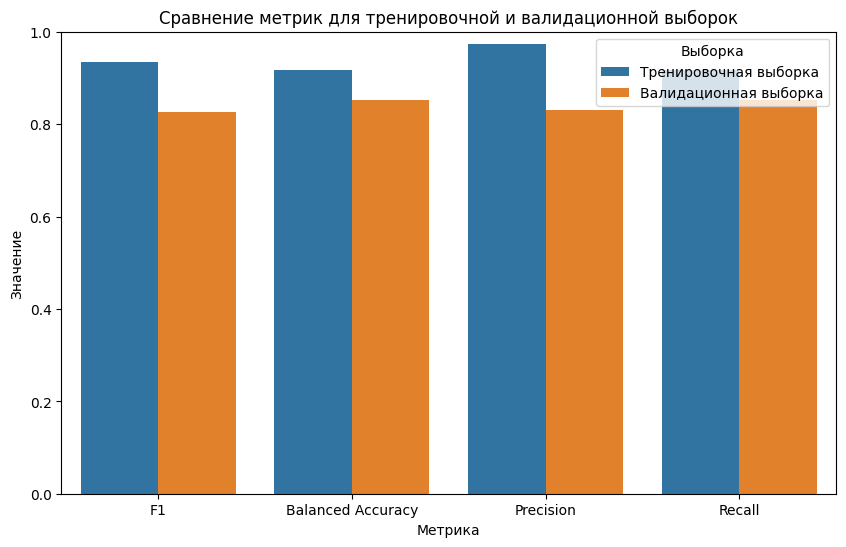

In [163]:
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df.melt(id_vars='Метрика', var_name='Выборка', value_name='Значение'),
            x='Метрика', y='Значение', hue='Выборка')
plt.title('Сравнение метрик для тренировочной и валидационной выборок')
plt.ylim(0, 1)
plt.legend(title='Выборка')
plt.show()

### Обучение с улучшенным бейзлайном

In [164]:
model = Pipeline((
    ("pca", PCA(n_components=7)),
    ("model", MyGradientBoostingClassifier())
))

In [165]:
model.fit(new_X_train, new_y_train)

Pipeline(steps=[('pca', PCA(n_components=7)),
                ('model',
                 <__main__.MyGradientBoostingClassifier object at 0x000002C47FF61E20>)])

In [166]:
train_predict = model.predict(new_X_train)
valid_predict = model.predict(new_X_valid)

###  Оценка качества модели

In [167]:
# Расчет метрик для тренировочных предсказаний
train_f1 = f1_score(new_y_train, train_predict, average='macro')
train_balanced_accuracy = balanced_accuracy_score(new_y_train, train_predict)
train_precision = precision_score(new_y_train, train_predict, average='macro', zero_division=1)
train_recall = recall_score(new_y_train, train_predict, average='macro')

# Расчет метрик для валидационных предсказаний
valid_f1 = f1_score(new_y_valid, valid_predict, average='macro')
valid_balanced_accuracy = balanced_accuracy_score(new_y_valid, valid_predict)
valid_precision = precision_score(new_y_valid, valid_predict, average='macro', zero_division=1)
valid_recall = recall_score(new_y_valid, valid_predict, average='macro')

# Сводка метрик в таблицу для удобного отображения
metrics_df = pd.DataFrame({
    'Метрика': ['F1', 'Balanced Accuracy', 'Precision', 'Recall'],
    'Тренировочная выборка': [train_f1, train_balanced_accuracy, train_precision, train_recall],
    'Валидационная выборка': [valid_f1, valid_balanced_accuracy, valid_precision, valid_recall]
    })

In [168]:
metrics_df.head()

,Метрика,Тренировочная выборка,Валидационная выборка
0,F1,0.982443,0.863158
1,Balanced Accuracy,0.982456,0.862963
2,Precision,0.983120,0.872054
3,Recall,0.982456,0.862963


Визуализация

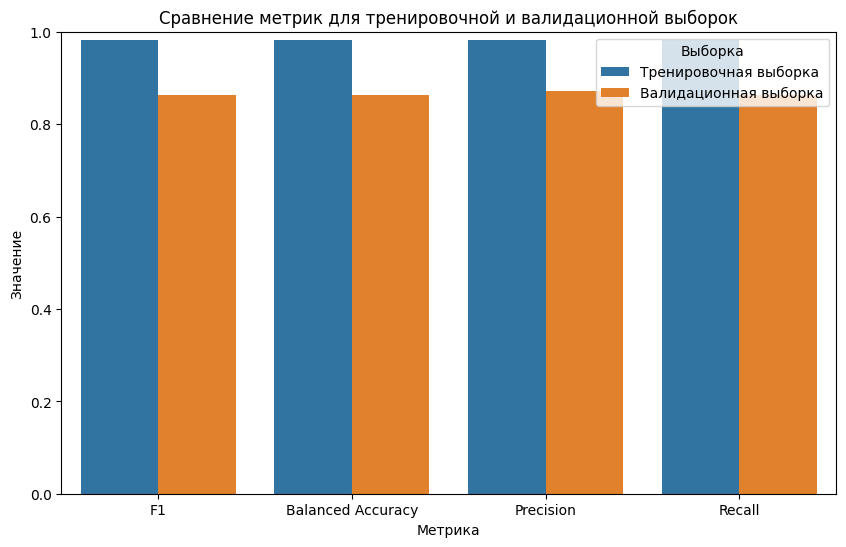

In [169]:
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df.melt(id_vars='Метрика', var_name='Выборка', value_name='Значение'),
            x='Метрика', y='Значение', hue='Выборка')
plt.title('Сравнение метрик для тренировочной и валидационной выборок')
plt.ylim(0, 1)
plt.legend(title='Выборка')
plt.show()